# Building phylogenetic trees

Since we are keeping the Archaea in our data this time, we need to make our trees separately for Bacteria and Archaea.

## Setting variables

In [35]:
import os
baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset'
workDir = os.path.join(baseDir, "phylogeny")
OTUFileDir = os.path.join(baseDir, "OTU_binning")
OTUFile = os.path.join(OTUFileDir, 'otusn.pick.fasta')
physeqDir = os.path.join(baseDir, "phyloseq")
physeqFile = os.path.join(physeqDir, "fullcyc2physeq.RDS")

nprocs = 20

## Initiate

In [37]:
import numpy as np
import pandas as pd
from cogent.app.fasttree import build_tree_from_alignment
from cogent import DNA, LoadSeqs
from Bio import Entrez
Entrez.email = "chuck.peperanney@gmail.com"
from IPython.display import display, Image, SVG


In [15]:
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [16]:
%%R
library(dplyr)
library(tidyr)
library(tibble)
library(phyloseq)
library(ggplot2)
library(ape)

In [17]:
if not os.path.isdir(workDir):
    print("Working directory does not exist. Making it now:")
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/phylogeny


### Check your files

In [18]:
!head -n 6 $OTUFile

>OTU.1
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGACCGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTGGTGACTGGCAAGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGG
>OTU.2
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCGCTAAGACAGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTTGTGACTGGCGGGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGG
>OTU.3
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACAAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG


In [19]:
!printf "Number of OTUs in fasta: "
!grep -c ">" $OTUFile

Number of OTUs in fasta: 30810


In [20]:
%%R -i physeqFile
physeq = readRDS(physeqFile)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30808 taxa and 2295 samples ]
sample_data() Sample Data:       [ 2295 samples by 38 sample variables ]
tax_table()   Taxonomy Table:    [ 30808 taxa by 7 taxonomic ranks ]


## Bacterial tree

### Pull out just bacterial OTUs according to the taxonomy file

In [21]:
%%R
tax.df = data.frame(tax_table(physeq)) %>%
    rownames_to_column(var="OTU") %>%
    filter(Domain == "Bacteria") %>%
    dplyr::select(OTU, Domain)

write.table(tax.df, file="bacterial_OTUs.txt", quote=F, sep="\t", row.names=F, col.names=F)

In [22]:
!grep -c "OTU" bacterial_OTUs.txt

30682


In [23]:
!filter_fasta.py -f $OTUFile -s bacterial_OTUs.txt -o fullcyc2.bact.fasta


In [24]:
!grep -c ">" fullcyc2.bact.fasta

30682


### Using SSU-Align to align seqs and masking based on alignment posterior probabilities.

In [25]:
!ssu-prep -f -x -b 50 --rfonly --dna fullcyc2.bact.fasta ssu_aln $nprocs

# ssu-prep :: prepare SSU rRNA sequences for parallel ssu-align jobs
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-prep -x -f -b 50 --dna --rfonly fullcyc2.bact.fasta ssu_aln 20
# date:    Tue Jul 31 12:56:16 2018
#
# Validating input sequence file ... done.
#
# Preparing 20 ssu-align jobs ...
# Partitioning seqs with goal of equalizing total number of nucleotides per job ...
#
# output file name       description                                            
# ---------------------  -------------------------------------------------------
  ssu_aln/fullcyc2.bact.fasta.1  partition  1 FASTA sequence file (1534 seqs; 388327 nt)
  ssu_aln/fullcyc2.bact.fasta.2  partition  2 FASTA sequence file (1534 seqs; 388357 nt)
  ssu_aln/fullcyc2.bact.fasta.3  partition  3 FASTA sequence file (1535 seqs; 388490 nt)
  ssu_aln

In [26]:
!./ssu_aln.ssu-align.sh

# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.1 ssu_aln/ssu_aln.1 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.2 ssu_aln/ssu_aln.2 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.3 ssu_aln/ssu_aln.3 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.4 ssu_aln/ssu_aln.4 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.5 ssu_aln/ssu_aln.5 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.6 ssu_aln/ssu_aln.6 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.7 ssu_aln/ssu_aln.7 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.8 ssu_aln/ssu_aln.8 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.bact.fasta.9 ssu_aln/ssu_aln.9 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ss

In [27]:
!ssu-mask --dna --afa ssu_aln

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask --afa --dna ssu_aln
# date:    Tue Jul 31 12:58:37 2018
#
# Masking alignments based on posterior probabilities...
#
#                                                     mask    
#                                                 ------------
# file name                  in/out  type  #cols  incl.  excl.
# -------------------------  ------  ----  -----  -----  -----
  ssu_aln.bacteria.stk        input   aln   1582      -      -
  ssu_aln.bacteria.mask      output  mask   1582    248   1334
  ssu_aln.bacteria.mask.pdf  output   pdf   1582    248   1334
  ssu_aln.bacteria.mask.afa  output   aln    248      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#
# List of executed commands saved in

### Using Sulfolobus as the root (acc. X90478).

In [28]:
sso_acc = "X90478"
sso_fa = Entrez.efetch(db="nucleotide", id=sso_acc, rettype="fasta", retmode="text").readlines()

In [29]:
out = open(os.path.join(workDir, 'X90478.fasta'), 'w')
sso_fa_namestrip = sso_fa[1:]
sso_fa_namestrip.insert(0,">%s\n"%sso_acc)
out.writelines(sso_fa_namestrip)
out.close()

In [30]:
!head -n 4 X90478.fasta

>X90478
TCCTGCCGGTCCCGACCGCTATCGGGGTGGGGCTAAGCCATGGGAGTCGTACGCTCCCGGGCAAGGGAGC
GTGGCGGACGGCTGAGTAACACGTGGCTAACCTACCCTGAGGAGGGAGATAACCCCGGGAAACTGGGGAT
AATCTCCCATAGGCGAGGAGTCCTGGAACGGTTCCTCGCTGAAAGGCTCATGGGCTATTCCCCGCTCATG


### Align the outgroup to the same cm (use the same mask that was established earlier).

In [31]:
!ssu-align -f -n bacteria --dna --rfonly X90478.fasta sso_aln

# ssu-align :: align SSU rRNA sequences
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-align -f -n bacteria --dna --rfonly X90478.fasta sso_aln
# date:    Tue Jul 31 12:58:40 2018
#
# Validating input sequence file ... done.
#
# Stage 1: Determining SSU start/end positions and best-matching models...
#
# output file name          description                                
# ------------------------  -------------------------------------------
  sso_aln.tab               locations/scores of hits defined by HMM(s)
  sso_aln.bacteria.hitlist  list of sequences to align with bacteria CM
  sso_aln.bacteria.fa             1 sequence  to align with bacteria CM
#
# Stage 2: Aligning each sequence to its best-matching model...
#
# output file name          description
# ------------------------  ---------------------

In [32]:
!ssu-mask -s ssu_aln/ssu_aln.bacteria.mask --dna --afa sso_aln/

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask -s ssu_aln/ssu_aln.bacteria.mask --afa --dna sso_aln/
# date:    Tue Jul 31 12:58:41 2018
#
# Masking alignments using pre-existing masks...
#
#                                                     mask    
#                                                 ------------
# file name                  in/out  type  #cols  incl.  excl.
# -------------------------  ------  ----  -----  -----  -----
  sso_aln.bacteria.stk        input   aln   1582      -      -
  ssu_aln.bacteria.mask       input  mask   1582    248   1334
  sso_aln.bacteria.mask.pdf  output   pdf   1582    248   1334
  sso_aln.bacteria.mask.afa  output   aln    248      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#
# List of 

In [33]:
!cat sso_aln/sso_aln.bacteria.mask.afa ssu_aln/ssu_aln.bacteria.mask.afa > aln_for_bact_tree.fasta

In [34]:
!head -n 20 aln_for_bact_tree.fasta

>X90478
TACCAGCCCCGCGAG---TGGTCGGGATTACTGGGCCTAAAGCGCCCGTAGCCGGCCCGA
CAAGTCACTCCTTAAAGACCCCGGCTCAACCGGGGGAAGGGTGATACTGTCGGGCTAGGG
GGCGGGAGAGGCCAGCGGTACTCCCGGAGTAGGGGCGAAATCCTCAGATCTCGGGAGGAC
CACCAGTGGCGAAAGCGGCTGGCTAGAACGCCCGACGGTGAGGGGCGAAAGCCGGGGCAG
CAAAAGGG
>OTU.1
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGT
TAAGACCGATGTGAAATCCCCGGGCTCAACCTGGGAACATTGGTGACTGGCAAGCTAGAG
TATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAA
TACCGATGGCGAAGGCAGCCCCCTGGGCCAACTGACGCTCATGCACGAAAGCGTGGGGAG
CAAACAGG
>OTU.2
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCGC
TAAGACAGATGTGAAATCCCCGGGCTTAACCTGGGAACATTTGTGACTGGCGGGCTAGAG
TATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAA
TACCGATGGCGAAGGCAGCCCCCTGGGCCAACTGACGCTCATGCACGAAAGCGTGGGGAG
CAAACAGG
>OTU.3
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGT


### Inferring and rooting the tree

* 1000 'bootstrap' replicates (default)

In [23]:
tree_file = 'fullcyc2.bacteria.tre'
!make_phylogeny.py -i aln_for_bact_tree.fasta -t fasttree -o $tree_file -l tree.log

In [24]:
tree_file

'fullcyc2.bacteria.tre'

## Using cogent

In [39]:
aln = LoadSeqs(os.path.join(workDir, 'aln_for_bact_tree.fasta'), moltype=DNA)
t_unroot = build_tree_from_alignment(aln, moltype=DNA)

In [40]:
t_rooted = t_unroot.rootedWithTip(sso_acc)

In [41]:
t_rooted.writeToFile(os.path.join(workDir, 'fullcyc2.bacteria.cogent.tree'))

## Archaeal tree

### Pull out just Archaeal OTUs according to the taxonomy file

In [42]:
%%R
tax.df = data.frame(tax_table(physeq)) %>%
    rownames_to_column(var="OTU") %>%
    filter(Domain == "Archaea") %>%
    dplyr::select(OTU, Domain)

write.table(tax.df, file="archaeal_OTUs.txt", quote=F, sep="\t", row.names=F, col.names=F)

In [43]:
!grep -c "OTU" archaeal_OTUs.txt

126


In [44]:
!filter_fasta.py -f $OTUFile -s archaeal_OTUs.txt -o fullcyc2.arch.fasta


In [45]:
!grep -c ">" fullcyc2.arch.fasta

126


### Using SSU-Align to align seqs and masking based on alignment posterior probabilities.


In [46]:
!ssu-prep -f -x -b 50 --rfonly --dna fullcyc2.arch.fasta ssu_aln 20 

# ssu-prep :: prepare SSU rRNA sequences for parallel ssu-align jobs
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-prep -x -f -b 50 --dna --rfonly fullcyc2.arch.fasta ssu_aln 20
# date:    Tue Jul 31 13:25:54 2018
#
# Validating input sequence file ... done.
#
# Preparing 20 ssu-align jobs ...
# Partitioning seqs with goal of equalizing total number of nucleotides per job ...
#
# output file name       description                                       
# ---------------------  --------------------------------------------------
  ssu_aln/fullcyc2.arch.fasta.1  partition  1 FASTA sequence file (7 seqs; 1771 nt)
  ssu_aln/fullcyc2.arch.fasta.2  partition  2 FASTA sequence file (7 seqs; 1771 nt)
  ssu_aln/fullcyc2.arch.fasta.3  partition  3 FASTA sequence file (7 seqs; 1772 nt)
  ssu_aln/fullcyc2.arch.fasta.4  p

In [47]:
!./ssu_aln.ssu-align.sh

# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.1 ssu_aln/ssu_aln.1 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.2 ssu_aln/ssu_aln.2 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.3 ssu_aln/ssu_aln.3 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.4 ssu_aln/ssu_aln.4 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.5 ssu_aln/ssu_aln.5 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.6 ssu_aln/ssu_aln.6 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.7 ssu_aln/ssu_aln.7 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.8 ssu_aln/ssu_aln.8 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/fullcyc2.arch.fasta.9 ssu_aln/ssu_aln.9 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ss

In [48]:
!ssu-mask --dna --afa ssu_aln

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask --afa --dna ssu_aln
# date:    Tue Jul 31 13:25:59 2018
#
# Masking alignments based on posterior probabilities...
#
#                                                    mask    
#                                                ------------
# file name                 in/out  type  #cols  incl.  excl.
# ------------------------  ------  ----  -----  -----  -----
  ssu_aln.archaea.stk        input   aln   1508      -      -
  ssu_aln.archaea.mask      output  mask   1508    250   1258
  ssu_aln.archaea.mask.pdf  output   pdf   1508    250   1258
  ssu_aln.archaea.mask.afa  output   aln    250      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#
# List of executed commands saved in:     ss

### Using E. coli as the root (acc. J01859)

In [49]:
sso_acc = "J01859"
sso_fa = Entrez.efetch(db="nucleotide", id=sso_acc, rettype="fasta", retmode="text").readlines()

In [50]:
out = open(os.path.join(workDir, 'J01859.fasta'), 'w')
sso_fa_namestrip = sso_fa[1:]
sso_fa_namestrip.insert(0,">%s\n"%sso_acc)
out.writelines(sso_fa_namestrip)
out.close()

In [51]:
!head -n 4 J01859.fasta

>J01859
AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGT
AACAGGAAGAAGCTTGCTCTTTGCTGACGAGTGGCGGACGGGTGAGTAATGTCTGGGAAACTGCCTGATG
GAGGGGGATAACTACTGGAAACGGTAGCTAATACCGCATAACGTCGCAAGACCAAAGAGGGGGACCTTCG


### Align the outgroup to the same cm (use the same mask that was established earlier).

In [52]:
!ssu-align -f -n archaea --dna --rfonly J01859.fasta sso_aln

# ssu-align :: align SSU rRNA sequences
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-align -f -n archaea --dna --rfonly J01859.fasta sso_aln
# date:    Tue Jul 31 13:26:02 2018
#
# Validating input sequence file ... done.
#
# Stage 1: Determining SSU start/end positions and best-matching models...
#
# output file name         description                                
# -----------------------  -------------------------------------------
  sso_aln.tab              locations/scores of hits defined by HMM(s)
  sso_aln.archaea.hitlist  list of sequences to align with archaea CM
  sso_aln.archaea.fa             1 sequence  to align with archaea CM
#
# Stage 2: Aligning each sequence to its best-matching model...
#
# output file name         description
# -----------------------  -------------------------------

In [53]:
!ssu-mask -s ssu_aln/ssu_aln.archaea.mask --dna --afa sso_aln/

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1.1 (Feb 2016)
# Copyright (C) 2016 Howard Hughes Medical Institute
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask -s ssu_aln/ssu_aln.archaea.mask --afa --dna sso_aln/
# date:    Tue Jul 31 13:26:03 2018
#
# Masking alignments using pre-existing masks...
#
#                                                    mask    
#                                                ------------
# file name                 in/out  type  #cols  incl.  excl.
# ------------------------  ------  ----  -----  -----  -----
  sso_aln.archaea.stk        input   aln   1508      -      -
  ssu_aln.archaea.mask       input  mask   1508    250   1258
  sso_aln.archaea.mask.pdf  output   pdf   1508    250   1258
  sso_aln.archaea.mask.afa  output   aln    250      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#
# List of executed 

In [54]:
!cat sso_aln/sso_aln.archaea.mask.afa ssu_aln/ssu_aln.archaea.mask.afa > aln_for_arch_tree.fasta

In [55]:
!head aln_for_arch_tree.fasta

>J01859
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGT
TAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACATCTGATACTGGCAAGCTTGAG
TCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAA
TACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGG
AGCAAACAGG
>OTU.36
TACCAGCACCCCGAGTGGTCGGGACGTTTATTGGGCCTAAAGCATCCGTAGCCGGTTCTA
CAAGTCTTCCGTTAAATCCACCTGCTTAACAGATGGGCGGAAGATACTATAGAGCTAGGA
GGCGGGAGAGGCAAGCGGTACTCGATGGGTAGGGGTAAAATCCGTTGATCCATTGAAGAC


### Inferring and rooting the tree

* 1000 'bootstrap' replicates (default)

In [45]:
tree_file = 'fullcyc2.archaea.tre'
!make_phylogeny.py -i aln_for_arch_tree.fasta -t fasttree -o $tree_file -l tree.log

In [46]:
tree_file

'fullcyc2.archaea.tre'

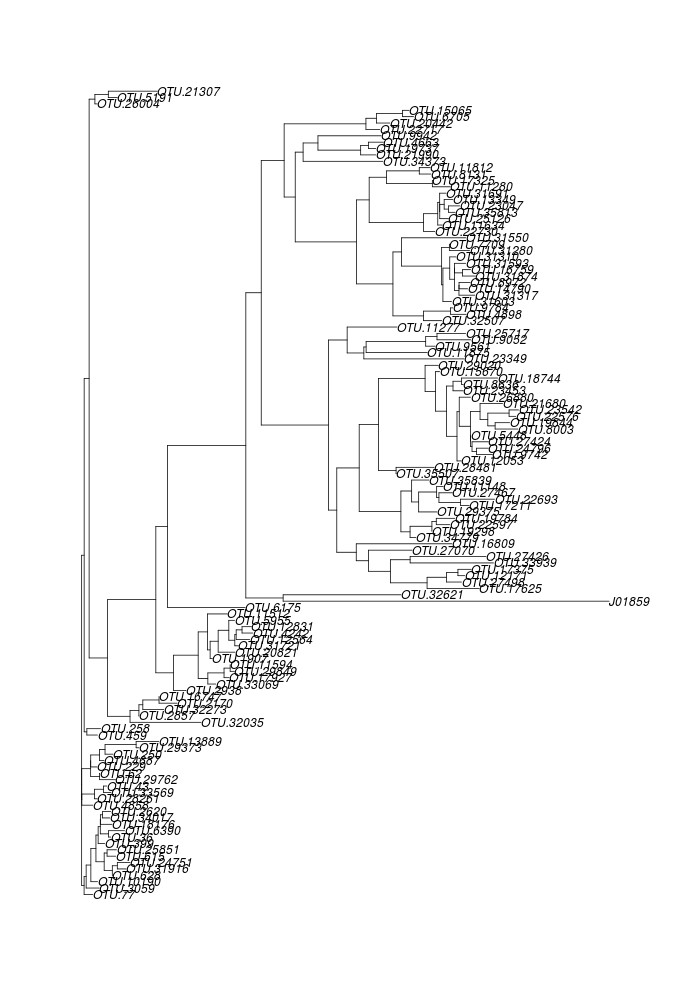

In [52]:
%%R -w 700 -h 1000 -i tree_file
tree = read.tree(tree_file)
plot(tree)

### Using Cogent

In [57]:
aln = LoadSeqs(os.path.join(workDir, 'aln_for_arch_tree.fasta'), moltype=DNA)
t_unroot = build_tree_from_alignment(aln, moltype=DNA)

In [58]:
t_rooted = t_unroot.rootedWithTip(sso_acc)

In [59]:
t_rooted.writeToFile(os.path.join(workDir, 'fullcyc2.archaea.cogent.tree'))

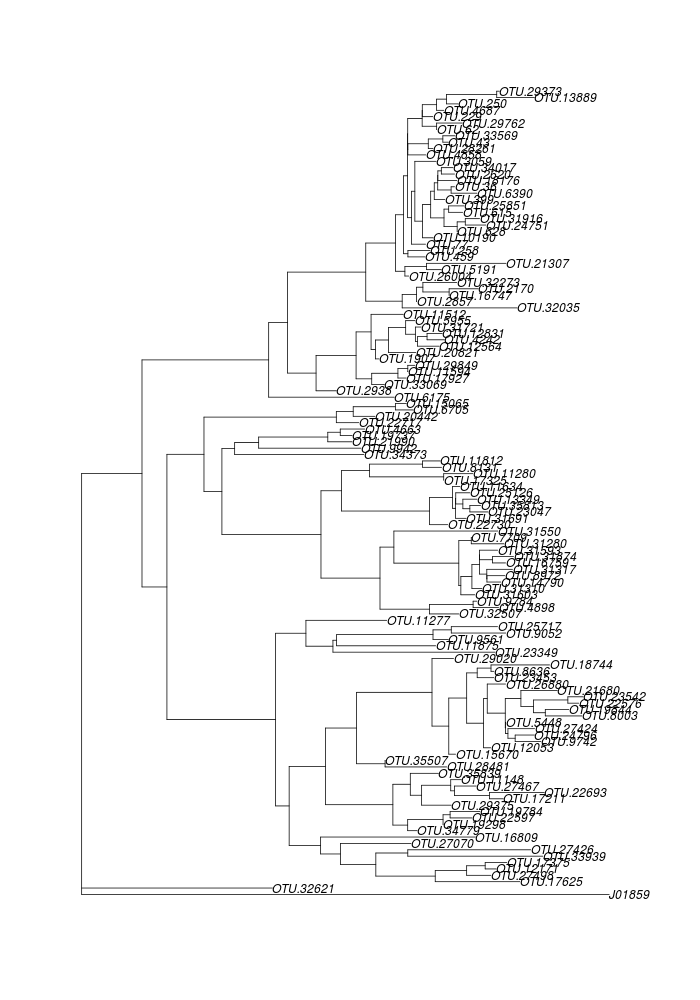

In [60]:
%%R -w 700 -h 1000
tree = read.tree("fullcyc2.archaea.cogent.tree")
plot(tree)